In [1]:
from tensorflow import keras 
import tensorflow as tf
from tensorflow.keras import layers, applications, losses
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D
import tensorflow.keras.backend as K
from tensorflow.keras.utils import get_file
import matplotlib.pyplot as plt
import pathlib 
from pathlib import Path, PurePath

import skimage
from skimage.transform import resize

import sys
import os
import h5py

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import Callback
import numpy as np
from PIL import Image

from tensorflow.python.framework.ops import enable_eager_execution
enable_eager_execution()


In [23]:
class VGG19AutoEncoder(tf.keras.Model):
    def __init__(self, files_path = "models/vgg_decoder"):
        super(VGG19AutoEncoder, self).__init__()
        #Load Full Model with every trained decoder
        
        
        #Get Each SubModel
        # Each model has an encoder, a decoder, and an extra output convolution
        # that converts the upsampled activations into output images
        
        # DO NOT load models four and five because they are not great auto encoders
        # and therefore will cause weird artifacts when used for style transfer 
        
        ModelBlock3 = tf.keras.models.load_model(str(PurePath(files_path, 'Block3_Model')), compile = False)
        self.E3 = ModelBlock3.layers[0] # VGG encoder
        self.D3 = ModelBlock3.layers[1] # Trained decoder from VGG
        self.O3 = ModelBlock3.layers[2] # Conv layer to get to three channels, RGB image
        
        ModelBlock2 = tf.keras.models.load_model(str(PurePath(files_path, 'Block2_Model')), compile = False)
        self.E2 = ModelBlock2.layers[0] # VGG encoder
        self.D2 = ModelBlock2.layers[1] # Trained decoder from VGG
        self.O2 = ModelBlock2.layers[2] # Conv layer to get to three channels, RGB image
        
        # no special decoder for this one becasue VGG first layer has
        # no downsampling. So the decoder is just a convolution 
        ModelBlock1 = tf.keras.models.load_model(str(PurePath(files_path, 'Block1_Model')), compile = False)
        self.E1 = ModelBlock1.layers[0] # VGG encoder, one layer
        self.O1 = ModelBlock1.layers[1] # Conv layer to get to three channels, RGB image
        
    def evaluate_decoder(self, image, alphas=None, training  = False):
        # Input will be the content image
        
        content_image = image
        
        output_dict = dict()
        # this will be the output, where each value is a styled 
        # version of the image at layer 1, 2, and 3. So each key in the 
        # dictionary corresponds to layer1, layer2, and layer3.
        # we also give back the reconstructed image from the auto encoder
        # so each value in the dict is a tuple (styled, reconstructed)
        
        # choose covariance function
        # covariance is more stable, but signal will work for very small images
        
        if alphas==None:
            alphas = {'layer3':0.6, 
                      'layer2':0.6, 
                      'layer1':0.6}
            
        print("Size of input: ", K.int_shape(content_image))
        
        # ------Layer 3----------
        # get reconstruction
        reconst3 = self.O3(self.D3(self.E3(tf.constant(content_image))))
        # save off the reconstructed images for display
        reconst3 = tf.clip_by_value(tf.squeeze(reconst3), 0, 1)
        output_dict['layer3'] = (reconst3)
        
        print("Size of reconst3: ", K.int_shape(reconst3))
        
        # ------Layer 2----------
        # get reconstruction
        reconst2 = self.O2(self.D2(self.E2(tf.constant(content_image))))
        # save off reconstructed images for display
        reconst2 = tf.clip_by_value(tf.squeeze(reconst2), 0, 1)
        output_dict['layer2'] = (reconst2)
        
        print("Size of reconst2: ", K.int_shape(reconst2))

        # ------Layer 1----------
        # get reconstruction
        reconst1 = self.O1(self.E1(tf.constant(content_image)))
        # save off the reconstructed images for display
        reconst1 = tf.clip_by_value(tf.squeeze(reconst1), 0, 1)
        output_dict['layer1'] = (reconst1)
        
        print("Size of reconst1: ", K.int_shape(reconst1))
           
        return output_dict
    
    def wct(self, content, style, alpha=0.6, eps=1e-5):
          
        # We squeeze the input to 3-D and transpose them
        # 1xHxWxC -> CxHxW
        content_transpose = np.transpose(np.squeeze(content), (2, 0, 1))
        style_transpose = np.transpose(np.squeeze(style), (2, 0, 1))

        # Flatten each channel into rows
        # CxHxW -> CxH*W
        content_flat = content_transpose.reshape(-1, content_transpose.shape[1]*content_transpose.shape[2])
        style_flat = style_transpose.reshape(-1, style_transpose.shape[1]*style_transpose.shape[2])

        # Threshold for eigenvalues
        eigen_val_thresh = 1e-5

        # ===Whitening transform===

        # We take the mean along each channel, while keeping each vector dimension. 
        mean_content = content_flat.mean(axis=1, keepdims=True)
        # We take the covariance by taking the difference between the channel and its expected value (mean).
        flat_content = content_flat - mean_content

        # Take the matricial dot product between the flat content and its transpose.
        cov_content = np.dot(flat_content, flat_content.T) / (content_transpose.shape[1]*content_transpose.shape[2] - 1)

        # Take the singular value decomposition (SVD), Uc = U-content Sc= S-content 
        Uc, Sc, _ = np.linalg.svd(cov_content)

        # Use threshold to truncate the SVD to only the largest EV.
        # Sum over the eigenvalues greater than the threshold, the vectors are arranged in descending order.
        k_c = (Sc > eigen_val_thresh).sum()

        # Create a diagonal matrix with the eigenvalues found before
        Dc = np.diag((Sc[:k_c]+eps)**-0.5) # Consistent with the paper on universal style transfer

        # Truncate the rectangular matrix as well.
        Uc = Uc[:,:k_c]

        # Now make a whitened content image
        fc_white = (Uc @ Dc @ Uc.T) @ flat_content

        # ===Coloring transform===

        # Same process as before for coloring using style 
        mean_style = style_flat.mean(axis=1, keepdims=True)
        flat_style = style_flat - mean_style

        # 2. get covariance of style, take SVD
        cov_style = np.dot(flat_style, flat_style.T) / (style_transpose.shape[1]*style_transpose.shape[2] - 1)
        # Us = U-style Ss= S-style 
        Us, Ss, _ = np.linalg.svd(cov_style)

        # 3. truncate the SVD to only the largest eigen values
        k_s = (Ss > eigen_val_thresh).sum()
        Ds = np.sqrt(np.diag(Ss[:k_s]+eps))
        Us = Us[:,:k_s]

        # 4. Now make a colored image that mixes the Grammian of the style
        #   with the whitened content image
        fcs_hat = (Us @ Ds @ Us.T) @ fc_white # Consistent with the paper
        fcs_hat = fcs_hat + mean_style # add style mean back to each channel

        # Blend transform features with original features, apply alpha to change intensity of style over the content image
        blended = alpha*fcs_hat + (1 - alpha)*(content_flat) 

        # Get back to the original shape
        # CxH*W -> CxHxW
        blended = blended.reshape(content_transpose.shape)
        # CxHxW -> 1xHxWxC
        blended = np.expand_dims(np.transpose(blended, (1,2,0)), 0)

        return np.float32(blended)


    def evaluate_wtc(self, image, alphas=None, training  = False):
        
    
        # Input should be dictionary with 'style' and 'content' keys
        # {'style':style_image, 'content':content_image}
        # value in each should be a 4D Tensor,: (batch, i,j, channel)

        style_image = image['style']
        content_image = image['content']

        output_dict = dict()
        # this will be the output, where each value is a styled 
        # version of the image at layer 1, 2, and 3. So each key in the 
        # dictionary corresponds to layer1, layer2, and layer3.
        # we also give back the reconstructed image from the auto encoder
        # so each value in the dict is a tuple (styled, reconstructed)

        x = content_image

        # ------Layer 3----------
        # apply whiten/color on layer 3 from the original image
        # get activations
        a_c = self.E3(tf.constant(x))
        a_s = self.E3(tf.constant(style_image))
        # swap grammian of activations, blended with original
        x = self.wct(content=a_c.numpy(), style=a_s.numpy(), alpha=0.6)
        # decode the new style
        x = self.O3(self.D3(x))
        x = self.enhance_contrast(x)
        # save off the styled and reconstructed images for display
        blended3 = tf.clip_by_value(tf.squeeze(x), 0, 1)

        return blended3


    @staticmethod
    def enhance_contrast(image, factor=1.25):
        return tf.image.adjust_contrast(image,factor)
        
    
       

In [ ]:
# Utilities

def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title==None:
        title = str(image.shape)
    else:
        title += ' '+str(image.shape)
    plt.title(title)
    


## Evaluate Encoder-Decoder
Use encoder-decoder to reconstruct content image.

Size of input:  (1, 287, 511, 3)
Size of reconst3:  (284, 508, 3)
Size of reconst2:  (286, 510, 3)
Size of reconst1:  (287, 511, 3)


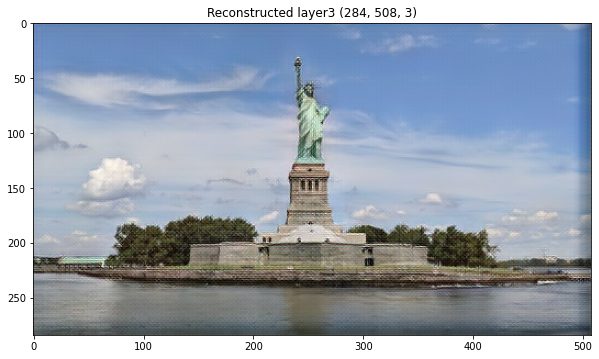

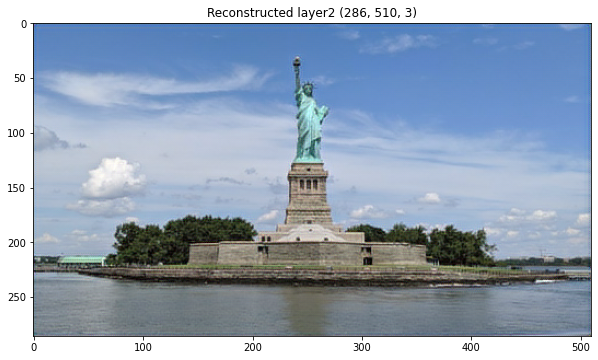

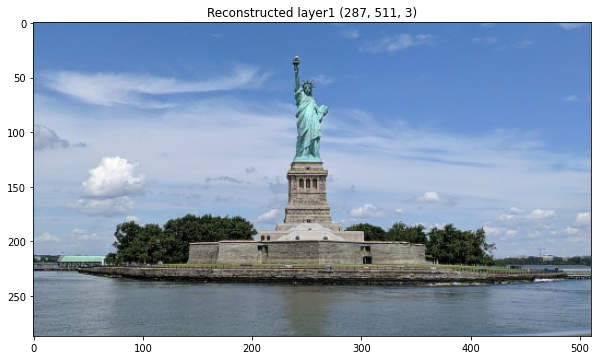

In [25]:
## Evaluate Decoder

# Load Model
AE = VGG19AutoEncoder('Block_Models')

# Load content
content_path = 'content2.jpg'

decoded_images = AE.evaluate_decoder(content_image)

for layer in decoded_images.keys():
    plt.figure(figsize=(10,10))
    imshow(decoded_images[layer],'Reconstructed '+layer)

## Evaluate Whitening-Coloring-Transform
Use the autoencoder along with whitening and coloring algorithms to create the blended image with a determined alpha.

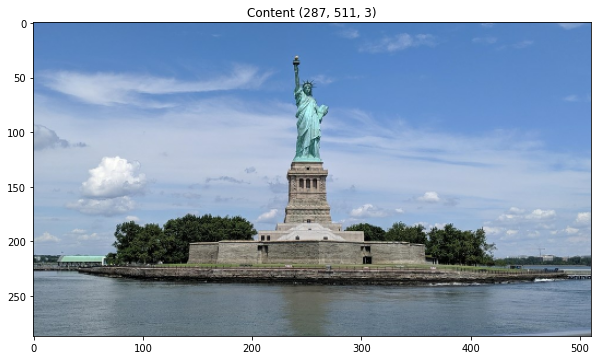

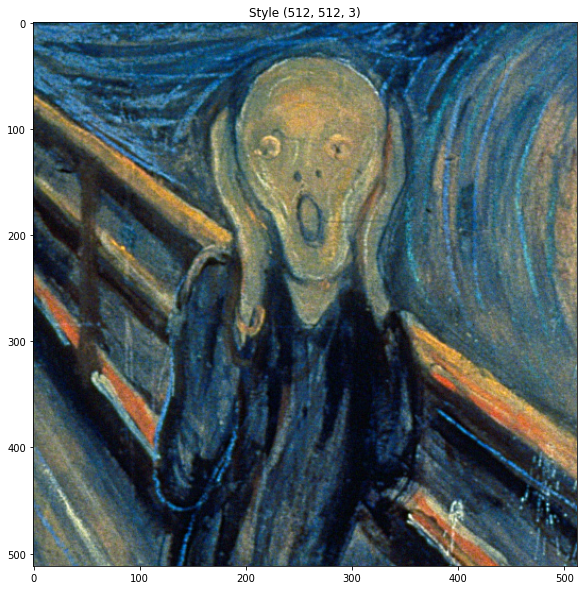

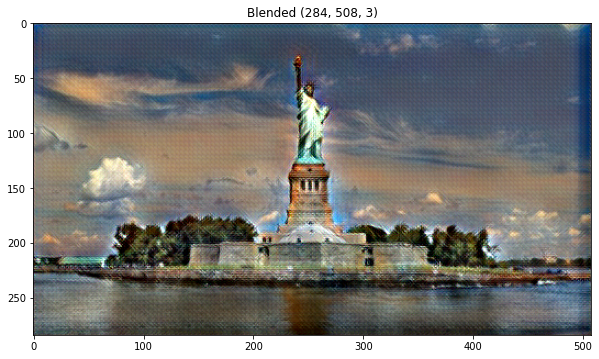

In [26]:
# Load Model
AE = VGG19AutoEncoder('Block_Models')

# Load content and style
content_path = 'content2.jpg'
style_path = 'style.jpg'

# Create dictionary
image = {
  "content": content_image,
  "style": style_image,
}

## Evaluate WTC
blended_image = AE.evaluate_wtc(image)

plt.figure(figsize=(10,10))
imshow(content_image,'Content')

plt.figure(figsize=(10,10))
imshow(style_image,'Style')

plt.figure(figsize=(10,10))
imshow(blended_image,'Blended')